In [1]:
import gaiaxpy as gxp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sdss

from astroML.sum_of_norms import sum_of_norms, norm
from astroquery.sdss import SDSS as aq_sdss
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
import warnings

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [3]:
# data-relevant constants
DF = pd.read_csv('../data/main_table.csv')
FIGURE_PATH = '../figures'

GAIA_ID_COLNAME = 'source_id'
SDSS_ID_COLNAME = 'specObjId'
NUM_NORMS = 800

In [4]:
# plot fontsize settings

SMALL_FONT_SIZE = 16
MEDIUM_FONT_SIZE = 20
LARGE_FONT_SIZE = 20

plt.rc('font', size=SMALL_FONT_SIZE)          # default text sizes
plt.rc('axes', titlesize=LARGE_FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_FONT_SIZE)   # fontsize of the figure title

In [5]:
# line properties

PROPS = {
    'sdss_raw': { 'color': '#AAAAAA', 'ls': '--', 'lw': 1, 'label': 'SDSS flux' },
    'gaussian': { 'color': '#FF4444', 'ls': '-', 'lw': 2, 'label': 'Gaussian fit to SDSS flux' },
    'gaia': {'color': '#4444FF', 'ls': '-', 'lw': 2, 'label': 'Gaia flux' }
}

In [6]:
def plot_w_props(x, y, props):
    plt.plot(x, y, color=props['color'], ls=props['ls'], lw=props['lw'], label=props['label'])

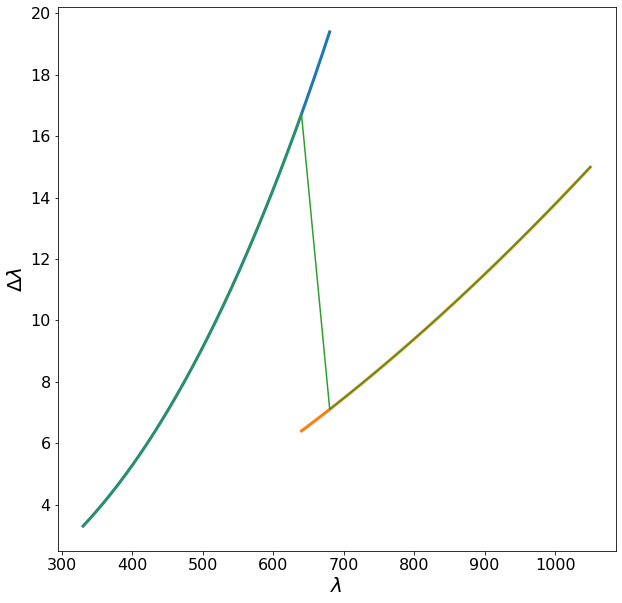

In [7]:
x1 = np.linspace(330, 680, 1000)
y1 = 3.30 * (x1/330)**2.45

x2 = np.linspace(640, 1050, 1000)
y2 = 6.40 * (x2/640)**1.72

plt.figure(figsize=(10, 10))
plt.plot(x1, y1, lw=3)
plt.plot(x2, y2, lw=3)

def deltaXP(wvl):
    y1 = lambda x: 3.30 * (x/330)**2.45
    y2 = lambda x: 6.40 * (x/640)**1.72
    y_mid = lambda x: (y2(680) * (x - 640) + y1(640) * (680 - x))/40
    
    return np.piecewise(wvl, \
                        [wvl < 640, (640 <= wvl) & (wvl <= 680), wvl > 680], \
                        [y1, y_mid, y2])
#     return np.piecewise(wvl, \
#                         [wvl < 660, wvl >= 660], \
#                         [y1, y2])
    
x = np.linspace(330, 1050, 2000)
plt.xlabel('$\\lambda$')
plt.ylabel('$\\Delta\\lambda$')
plt.plot(x, deltaXP(x))

In [8]:
def plot_conv(*, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # const (test)
#     sdss_flux = np.array([np.mean(sdss_flux)] * len(sdss_flux))
    
    # get gaia data and calibrate using sdss sampling
    gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]

    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
#     sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(locs)**2)  # convolve gaussian sigmas with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.mean(sdss_conv[mask]/gaia_flux[mask])

    # plot the results

    plt.figure(figsize=(20, 10))
    plot_w_props(sdss_sampling, sdss_flux, PROPS['sdss_raw'])
    plot_w_props(sdss_sampling, sdss_conv, PROPS['gaussian'])
    plot_w_props(sdss_sampling, gaia_flux, PROPS['gaia'])

    plt.legend(loc=0)

    plt.text(0.97, 0.8, f"gaussian fit rms error = {fit_rms:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.75, f"k = {k:.2}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.7, f"sdss - gaia rms error = {match_rms:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.65, f"sdss/gaia quotient = {quot:.3}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.6, f"integrated flux (raw) = {raw_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.55, f"integrated flux (fit) = {fit_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.text(0.97, 0.5, f"integrated flux (conv) = {conv_flux:.5}", ha='right', va='top', transform=plt.gca().transAxes)
    plt.title(f"Gaia source_id {gaia_id}\n SDSS specObjId {sdss_id}")
    
    plt.xlabel('$\\lambda$ [nm]')
    plt.ylabel('flux [W m$^{-2}$ nm$^{-1}$]')
    
    plt.xlim(350, 950)
    plt.xticks(np.arange(360, 960, 20))
    
    for axis in [ 'top', 'bottom', 'left', 'right' ]:
        plt.gca().spines[axis].set_linewidth(2)
    
    if not os.path.exists(FIGURE_PATH):
        os.mkdir(FIGURE_PATH)

    plt.savefig(f'{FIGURE_PATH}/gaia_{gaia_id}_sdss_{sdss_id}_k_{int(k*10)}.png')
    plt.show()

In [9]:
def plot_conv_get_gaia(*, gaia_id=None, sdss_id=None):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    # get gaia data and calibrate using sdss sampling
    while True:
        try:
            print('calibrating gaia...')
            gaia_flux = gxp.calibrate([gaia_id], sampling=sdss_sampling, truncation=True)[0]['flux'][0]
            print('done.')
            return gaia_flux
        except Exception as e:
            print(e)
            continue

In [10]:
def plot_conv_k_rms(gaia_flux, *, gaia_id=None, sdss_id=None, k=1):
    if gaia_id is None and sdss_id is None:
        print('No ID supplied')
    elif sdss_id is None:    
        try:
            sdss_id = DF.loc[DF[GAIA_ID_COLNAME] == gaia_id][SDSS_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an SDSS ID corresponding to the provided Gaia ID')
    elif gaia_id is None:
        try:
            gaia_id = DF.loc[DF[SDSS_ID_COLNAME] == sdss_id][GAIA_ID_COLNAME].to_list()[0]
        except:
            print('Could not find an Gaia ID corresponding to the provided SDSS ID')
            
    # get sdss data
    try:
        sp = sdss.SpecObj(int(sdss_id))
        data = aq_sdss.get_spectra(plate=sp.plate, mjd=sp.mjd, fiberID=sp.fiberID)
    except:
        print('Could not get SDSS data')
        return
    
    spec_data = data[0][1].data

    sdss_sampling = 10 ** spec_data['loglam'] / 10  # Convert log wavelength to linear and Å to nm
    sdss_flux = spec_data['flux'] * 1e-19 # Convert SDSS units (1e-17 in cgs) to Gaia units (SI)
    
    weights, fit_rms, locs, widths = sum_of_norms(sdss_sampling, sdss_flux, NUM_NORMS,
                                                 spacing='linear',
                                                 full_output=True)
    
    # convolve sdss with sigma_gaia
    sigma_conv = np.sqrt(widths**2 + k**2 * deltaXP(sdss_sampling[:, None])**2)  # convolve gaussian sigmas with sigma_gaia
    sdss_flux_fit = (weights * norm(sdss_sampling[:, None], locs, widths)).sum(1)
    sdss_conv = (weights * norm(sdss_sampling[:, None], locs, sigma_conv)).sum(1)
    
    # integrate flux as sanity check
    mask = (sdss_sampling > 390) & (sdss_sampling < 900)
    raw_flux = np.trapz(sdss_flux[mask], sdss_sampling[mask])
    fit_flux = np.trapz(sdss_flux_fit[mask], sdss_sampling[mask])
    conv_flux = np.trapz(sdss_conv[mask], sdss_sampling[mask])
    
    # compute rms error and quotient between sdss convolution and gaia data
    match_rms = np.sqrt(np.mean((sdss_conv[mask] - gaia_flux[mask])**2))
    quot = np.median(sdss_conv/gaia_flux)

    return match_rms, quot

In [11]:
ks = {}
qs = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.20, 1.800001, 0.02):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks[gaia_id] = min_k
    qs[gaia_id] = min_q

  0%|                                                                                                                                                                                                                                 | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▏                                                                                                                                                                                                                      | 1/1000 [00:13<3:48:41, 13.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▍                                                                                                                                                                                                                      | 2/1000 [00:20<2:42:22,  9.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▋                                                                                                                                                                                                                      | 3/1000 [00:28<2:26:24,  8.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|▊                                                                                                                                                                                                                      | 4/1000 [00:35<2:17:19,  8.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  0%|█                                                                                                                                                                                                                      | 5/1000 [00:44<2:19:04,  8.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▎                                                                                                                                                                                                                     | 6/1000 [01:16<4:29:52, 16.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▌                                                                                                                                                                                                                     | 7/1000 [01:25<3:55:11, 14.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|█▋                                                                                                                                                                                                                     | 8/1000 [01:33<3:19:12, 12.05s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▎                                                                                                                                                                                                                   | 11/1000 [02:05<3:05:07, 11.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▌                                                                                                                                                                                                                   | 12/1000 [02:10<2:43:36,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▊                                                                                                                                                                                                                   | 13/1000 [02:47<4:28:19, 16.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  1%|██▉                                                                                                                                                                                                                   | 14/1000 [02:56<3:55:46, 14.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▏                                                                                                                                                                                                                  | 15/1000 [03:09<3:51:55, 14.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▍                                                                                                                                                                                                                  | 16/1000 [03:14<3:11:11, 11.66s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|███▊                                                                                                                                                                                                                  | 18/1000 [03:19<2:04:11,  7.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████                                                                                                                                                                                                                  | 19/1000 [03:29<2:14:31,  8.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▎                                                                                                                                                                                                                 | 20/1000 [03:39<2:21:29,  8.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▍                                                                                                                                                                                                                 | 21/1000 [04:11<4:03:13, 14.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▋                                                                                                                                                                                                                 | 22/1000 [04:18<3:28:21, 12.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|████▉                                                                                                                                                                                                                 | 23/1000 [04:55<5:16:55, 19.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|█████▏                                                                                                                                                                                                                | 24/1000 [05:03<4:23:29, 16.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  2%|█████▎                                                                                                                                                                                                                | 25/1000 [05:10<3:37:57, 13.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|█████▌                                                                                                                                                                                                                | 26/1000 [05:19<3:20:24, 12.35s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|██████▍                                                                                                                                                                                                               | 30/1000 [05:56<2:48:15, 10.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|██████▊                                                                                                                                                                                                               | 32/1000 [06:05<2:17:32,  8.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|███████                                                                                                                                                                                                               | 33/1000 [06:11<2:09:04,  8.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  3%|███████▎                                                                                                                                                                                                              | 34/1000 [06:19<2:09:31,  8.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|███████▍                                                                                                                                                                                                              | 35/1000 [06:28<2:12:31,  8.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|███████▋                                                                                                                                                                                                              | 36/1000 [06:56<3:29:45, 13.06s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▏                                                                                                                                                                                                             | 38/1000 [07:07<2:38:39,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▎                                                                                                                                                                                                             | 39/1000 [07:16<2:36:16,  9.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▌                                                                                                                                                                                                             | 40/1000 [07:38<3:26:19, 12.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▊                                                                                                                                                                                                             | 41/1000 [07:50<3:21:24, 12.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|████████▉                                                                                                                                                                                                             | 42/1000 [08:01<3:12:28, 12.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▏                                                                                                                                                                                                            | 43/1000 [08:10<3:00:14, 11.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▍                                                                                                                                                                                                            | 44/1000 [08:19<2:48:52, 10.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  4%|█████████▋                                                                                                                                                                                                            | 45/1000 [08:31<2:53:58, 10.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|█████████▊                                                                                                                                                                                                            | 46/1000 [08:39<2:42:40, 10.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████                                                                                                                                                                                                            | 47/1000 [08:49<2:38:48, 10.00s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▍                                                                                                                                                                                                           | 49/1000 [08:58<2:00:53,  7.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▋                                                                                                                                                                                                           | 50/1000 [09:06<1:59:45,  7.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|██████████▉                                                                                                                                                                                                           | 51/1000 [09:17<2:13:39,  8.45s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|███████████▎                                                                                                                                                                                                          | 53/1000 [09:26<1:47:58,  6.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  5%|███████████▌                                                                                                                                                                                                          | 54/1000 [09:34<1:54:07,  7.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|███████████▊                                                                                                                                                                                                          | 55/1000 [09:41<1:51:01,  7.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|███████████▉                                                                                                                                                                                                          | 56/1000 [09:53<2:13:27,  8.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▏                                                                                                                                                                                                         | 57/1000 [10:04<2:20:35,  8.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▍                                                                                                                                                                                                         | 58/1000 [10:20<2:52:12, 10.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▋                                                                                                                                                                                                         | 59/1000 [10:26<2:32:57,  9.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|████████████▊                                                                                                                                                                                                         | 60/1000 [10:36<2:32:13,  9.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████                                                                                                                                                                                                         | 61/1000 [10:43<2:18:31,  8.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▎                                                                                                                                                                                                        | 62/1000 [10:52<2:21:16,  9.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▍                                                                                                                                                                                                        | 63/1000 [11:05<2:38:20, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▋                                                                                                                                                                                                        | 64/1000 [11:12<2:23:41,  9.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  6%|█████████████▉                                                                                                                                                                                                        | 65/1000 [11:23<2:33:31,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████                                                                                                                                                                                                        | 66/1000 [11:33<2:34:04,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▎                                                                                                                                                                                                       | 67/1000 [11:42<2:25:53,  9.38s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▊                                                                                                                                                                                                       | 69/1000 [11:52<1:56:22,  7.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|██████████████▉                                                                                                                                                                                                       | 70/1000 [12:01<2:01:34,  7.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▏                                                                                                                                                                                                      | 71/1000 [12:11<2:10:09,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▍                                                                                                                                                                                                      | 72/1000 [12:21<2:17:33,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  7%|███████████████▌                                                                                                                                                                                                      | 73/1000 [12:33<2:29:36,  9.68s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████                                                                                                                                                                                                      | 75/1000 [12:43<1:56:28,  7.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▎                                                                                                                                                                                                     | 76/1000 [12:51<2:00:01,  7.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▍                                                                                                                                                                                                     | 77/1000 [13:02<2:12:25,  8.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▋                                                                                                                                                                                                     | 78/1000 [13:17<2:35:41, 10.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|████████████████▉                                                                                                                                                                                                     | 79/1000 [13:26<2:32:01,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████                                                                                                                                                                                                     | 80/1000 [13:32<2:16:20,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▎                                                                                                                                                                                                    | 81/1000 [13:41<2:14:25,  8.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▌                                                                                                                                                                                                    | 82/1000 [13:52<2:24:18,  9.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▊                                                                                                                                                                                                    | 83/1000 [14:02<2:25:56,  9.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|█████████████████▉                                                                                                                                                                                                    | 84/1000 [14:13<2:32:38, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  8%|██████████████████▏                                                                                                                                                                                                   | 85/1000 [14:22<2:28:32,  9.74s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|██████████████████▌                                                                                                                                                                                                   | 87/1000 [14:33<1:58:52,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|██████████████████▊                                                                                                                                                                                                   | 88/1000 [14:41<1:58:34,  7.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████                                                                                                                                                                                                   | 89/1000 [14:49<2:01:08,  7.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▎                                                                                                                                                                                                  | 90/1000 [14:58<2:05:54,  8.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▍                                                                                                                                                                                                  | 91/1000 [15:10<2:21:50,  9.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▋                                                                                                                                                                                                  | 92/1000 [15:20<2:23:06,  9.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|███████████████████▉                                                                                                                                                                                                  | 93/1000 [15:31<2:29:28,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


  9%|████████████████████                                                                                                                                                                                                  | 94/1000 [15:43<2:36:23, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▎                                                                                                                                                                                                 | 95/1000 [15:55<2:44:10, 10.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▌                                                                                                                                                                                                 | 96/1000 [16:03<2:31:52, 10.08s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|████████████████████▉                                                                                                                                                                                                 | 98/1000 [16:13<1:57:45,  7.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▏                                                                                                                                                                                                | 99/1000 [16:24<2:08:00,  8.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▎                                                                                                                                                                                               | 100/1000 [16:33<2:10:25,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▌                                                                                                                                                                                               | 101/1000 [16:46<2:27:03,  9.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▋                                                                                                                                                                                               | 102/1000 [16:57<2:30:18, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|█████████████████████▉                                                                                                                                                                                               | 103/1000 [17:10<2:45:20, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 10%|██████████████████████▏                                                                                                                                                                                              | 104/1000 [17:43<4:17:30, 17.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|██████████████████████▌                                                                                                                                                                                              | 106/1000 [17:54<2:59:07, 12.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|██████████████████████▊                                                                                                                                                                                              | 107/1000 [18:05<2:54:44, 11.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████                                                                                                                                                                                              | 108/1000 [18:15<2:48:35, 11.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▏                                                                                                                                                                                             | 109/1000 [18:24<2:38:15, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▍                                                                                                                                                                                             | 110/1000 [18:29<2:13:59,  9.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▋                                                                                                                                                                                             | 111/1000 [18:38<2:13:02,  8.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|███████████████████████▊                                                                                                                                                                                             | 112/1000 [18:48<2:18:19,  9.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|████████████████████████                                                                                                                                                                                             | 113/1000 [19:19<3:53:49, 15.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 11%|████████████████████████▎                                                                                                                                                                                            | 114/1000 [19:38<4:07:44, 16.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▍                                                                                                                                                                                            | 115/1000 [19:47<3:30:18, 14.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▋                                                                                                                                                                                            | 116/1000 [20:00<3:25:00, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|████████████████████████▉                                                                                                                                                                                            | 117/1000 [20:08<2:59:57, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▏                                                                                                                                                                                           | 118/1000 [20:17<2:47:49, 11.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▎                                                                                                                                                                                           | 119/1000 [20:50<4:19:45, 17.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▌                                                                                                                                                                                           | 120/1000 [21:00<3:44:32, 15.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▊                                                                                                                                                                                           | 121/1000 [21:05<2:59:55, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|█████████████████████████▉                                                                                                                                                                                           | 122/1000 [21:14<2:46:35, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▏                                                                                                                                                                                          | 123/1000 [21:47<4:18:37, 17.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▍                                                                                                                                                                                          | 124/1000 [22:19<5:24:13, 22.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 12%|██████████████████████████▋                                                                                                                                                                                          | 125/1000 [22:25<4:12:43, 17.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|██████████████████████████▊                                                                                                                                                                                          | 126/1000 [22:35<3:38:49, 15.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████                                                                                                                                                                                          | 127/1000 [22:45<3:18:46, 13.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▎                                                                                                                                                                                         | 128/1000 [22:52<2:48:46, 11.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▍                                                                                                                                                                                         | 129/1000 [23:24<4:18:41, 17.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▋                                                                                                                                                                                         | 130/1000 [23:35<3:45:41, 15.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|███████████████████████████▉                                                                                                                                                                                         | 131/1000 [23:47<3:30:46, 14.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████                                                                                                                                                                                         | 132/1000 [23:55<3:03:17, 12.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████▎                                                                                                                                                                                        | 133/1000 [24:05<2:51:46, 11.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 13%|████████████████████████████▌                                                                                                                                                                                        | 134/1000 [24:19<2:58:25, 12.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|████████████████████████████▊                                                                                                                                                                                        | 135/1000 [24:26<2:36:43, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|████████████████████████████▉                                                                                                                                                                                        | 136/1000 [25:06<4:41:08, 19.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▏                                                                                                                                                                                       | 137/1000 [25:16<3:58:57, 16.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▍                                                                                                                                                                                       | 138/1000 [25:48<5:07:11, 21.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▌                                                                                                                                                                                       | 139/1000 [26:21<5:54:56, 24.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|█████████████████████████████▊                                                                                                                                                                                       | 140/1000 [26:33<4:58:42, 20.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████                                                                                                                                                                                       | 141/1000 [26:43<4:15:04, 17.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▏                                                                                                                                                                                      | 142/1000 [26:55<3:48:07, 15.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▍                                                                                                                                                                                      | 143/1000 [27:06<3:27:11, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▋                                                                                                                                                                                      | 144/1000 [27:14<3:00:19, 12.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 14%|██████████████████████████████▉                                                                                                                                                                                      | 145/1000 [27:27<3:00:29, 12.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████                                                                                                                                                                                      | 146/1000 [28:04<4:43:51, 19.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▌                                                                                                                                                                                     | 148/1000 [28:16<3:12:02, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▋                                                                                                                                                                                     | 149/1000 [28:27<3:01:55, 12.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|███████████████████████████████▉                                                                                                                                                                                     | 150/1000 [28:59<4:12:54, 17.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▏                                                                                                                                                                                    | 151/1000 [29:10<3:46:05, 15.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▌                                                                                                                                                                                    | 153/1000 [29:19<2:34:08, 10.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 15%|████████████████████████████████▊                                                                                                                                                                                    | 154/1000 [29:26<2:23:27, 10.17s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▏                                                                                                                                                                                   | 156/1000 [29:38<1:58:21,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▍                                                                                                                                                                                   | 157/1000 [29:51<2:11:37,  9.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▋                                                                                                                                                                                   | 158/1000 [30:00<2:10:03,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|█████████████████████████████████▊                                                                                                                                                                                   | 159/1000 [30:07<2:03:34,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████                                                                                                                                                                                   | 160/1000 [30:14<1:57:33,  8.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▎                                                                                                                                                                                  | 161/1000 [30:28<2:17:44,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▌                                                                                                                                                                                  | 162/1000 [30:44<2:40:31, 11.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▋                                                                                                                                                                                  | 163/1000 [30:55<2:38:32, 11.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|██████████████████████████████████▉                                                                                                                                                                                  | 164/1000 [31:05<2:35:42, 11.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 16%|███████████████████████████████████▏                                                                                                                                                                                 | 165/1000 [31:16<2:35:05, 11.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▎                                                                                                                                                                                 | 166/1000 [31:26<2:26:47, 10.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▌                                                                                                                                                                                 | 167/1000 [32:04<4:21:54, 18.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▊                                                                                                                                                                                 | 168/1000 [32:15<3:46:50, 16.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|███████████████████████████████████▉                                                                                                                                                                                 | 169/1000 [32:30<3:42:14, 16.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▏                                                                                                                                                                                | 170/1000 [32:44<3:32:46, 15.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▍                                                                                                                                                                                | 171/1000 [32:54<3:10:29, 13.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▋                                                                                                                                                                                | 172/1000 [33:08<3:13:24, 14.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|████████████████████████████████████▊                                                                                                                                                                                | 173/1000 [33:24<3:21:10, 14.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 17%|█████████████████████████████████████                                                                                                                                                                                | 174/1000 [33:36<3:07:20, 13.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▎                                                                                                                                                                               | 175/1000 [33:48<3:02:40, 13.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▍                                                                                                                                                                               | 176/1000 [34:01<3:01:25, 13.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▋                                                                                                                                                                               | 177/1000 [34:15<3:02:43, 13.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|█████████████████████████████████████▉                                                                                                                                                                               | 178/1000 [34:24<2:47:30, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▏                                                                                                                                                                              | 179/1000 [35:07<4:52:44, 21.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▎                                                                                                                                                                              | 180/1000 [35:24<4:33:07, 19.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▌                                                                                                                                                                              | 181/1000 [35:43<4:27:19, 19.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▊                                                                                                                                                                              | 182/1000 [35:48<3:27:57, 15.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|██████████████████████████████████████▉                                                                                                                                                                              | 183/1000 [35:57<3:02:32, 13.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|███████████████████████████████████████▏                                                                                                                                                                             | 184/1000 [36:08<2:51:32, 12.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 18%|███████████████████████████████████████▍                                                                                                                                                                             | 185/1000 [36:22<2:57:09, 13.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|███████████████████████████████████████▌                                                                                                                                                                             | 186/1000 [36:36<3:04:17, 13.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|███████████████████████████████████████▊                                                                                                                                                                             | 187/1000 [36:50<3:03:25, 13.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████                                                                                                                                                                             | 188/1000 [37:02<2:58:19, 13.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▎                                                                                                                                                                            | 189/1000 [37:14<2:52:00, 12.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▍                                                                                                                                                                            | 190/1000 [37:27<2:53:41, 12.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▋                                                                                                                                                                            | 191/1000 [37:39<2:48:03, 12.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|████████████████████████████████████████▉                                                                                                                                                                            | 192/1000 [37:47<2:29:44, 11.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|█████████████████████████████████████████                                                                                                                                                                            | 193/1000 [37:55<2:19:28, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 19%|█████████████████████████████████████████▎                                                                                                                                                                           | 194/1000 [38:32<4:04:22, 18.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▌                                                                                                                                                                           | 195/1000 [38:41<3:27:11, 15.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▋                                                                                                                                                                           | 196/1000 [38:51<3:04:15, 13.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|█████████████████████████████████████████▉                                                                                                                                                                           | 197/1000 [38:57<2:33:40, 11.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▏                                                                                                                                                                          | 198/1000 [39:10<2:41:35, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▍                                                                                                                                                                          | 199/1000 [39:23<2:46:06, 12.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|██████████████████████████████████████████▌                                                                                                                                                                          | 200/1000 [39:33<2:35:34, 11.67s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████                                                                                                                                                                          | 202/1000 [39:59<2:42:09, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▏                                                                                                                                                                         | 203/1000 [40:07<2:27:17, 11.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▍                                                                                                                                                                         | 204/1000 [40:47<4:06:57, 18.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 20%|███████████████████████████████████████████▋                                                                                                                                                                         | 205/1000 [40:56<3:33:17, 16.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|███████████████████████████████████████████▉                                                                                                                                                                         | 206/1000 [41:01<2:53:20, 13.10s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▎                                                                                                                                                                        | 208/1000 [41:13<2:11:35,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▌                                                                                                                                                                        | 209/1000 [41:23<2:11:40,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▋                                                                                                                                                                        | 210/1000 [41:33<2:10:53,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|████████████████████████████████████████████▉                                                                                                                                                                        | 211/1000 [41:42<2:05:58,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▏                                                                                                                                                                       | 212/1000 [41:54<2:13:29, 10.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▎                                                                                                                                                                       | 213/1000 [42:13<2:48:20, 12.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 21%|█████████████████████████████████████████████▌                                                                                                                                                                       | 214/1000 [42:25<2:45:44, 12.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|█████████████████████████████████████████████▊                                                                                                                                                                       | 215/1000 [42:33<2:25:56, 11.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████                                                                                                                                                                       | 216/1000 [42:43<2:21:44, 10.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▏                                                                                                                                                                      | 217/1000 [42:53<2:19:19, 10.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▍                                                                                                                                                                      | 218/1000 [43:06<2:27:55, 11.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▋                                                                                                                                                                      | 219/1000 [43:14<2:15:56, 10.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|██████████████████████████████████████████████▊                                                                                                                                                                      | 220/1000 [43:23<2:08:01,  9.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████                                                                                                                                                                      | 221/1000 [43:34<2:12:57, 10.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▎                                                                                                                                                                     | 222/1000 [43:46<2:17:41, 10.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▍                                                                                                                                                                     | 223/1000 [43:56<2:15:26, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▋                                                                                                                                                                     | 224/1000 [44:06<2:14:15, 10.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 22%|███████████████████████████████████████████████▉                                                                                                                                                                     | 225/1000 [44:42<3:52:17, 17.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▏                                                                                                                                                                    | 226/1000 [44:49<3:10:54, 14.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▎                                                                                                                                                                    | 227/1000 [44:56<2:42:28, 12.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▌                                                                                                                                                                    | 228/1000 [45:06<2:31:53, 11.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▊                                                                                                                                                                    | 229/1000 [45:19<2:33:21, 11.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|████████████████████████████████████████████████▉                                                                                                                                                                    | 230/1000 [45:31<2:36:29, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▏                                                                                                                                                                   | 231/1000 [45:39<2:17:01, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▍                                                                                                                                                                   | 232/1000 [45:51<2:22:30, 11.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▋                                                                                                                                                                   | 233/1000 [46:05<2:33:14, 11.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 23%|█████████████████████████████████████████████████▊                                                                                                                                                                   | 234/1000 [46:17<2:35:34, 12.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████                                                                                                                                                                   | 235/1000 [46:30<2:38:02, 12.40s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▍                                                                                                                                                                  | 237/1000 [46:40<1:52:59,  8.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▋                                                                                                                                                                  | 238/1000 [46:50<1:57:59,  9.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|██████████████████████████████████████████████████▉                                                                                                                                                                  | 239/1000 [46:59<1:55:58,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████                                                                                                                                                                  | 240/1000 [47:32<3:16:42, 15.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▎                                                                                                                                                                 | 241/1000 [47:40<2:51:36, 13.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▌                                                                                                                                                                 | 242/1000 [47:48<2:30:23, 11.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▊                                                                                                                                                                 | 243/1000 [47:56<2:16:30, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|███████████████████████████████████████████████████▉                                                                                                                                                                 | 244/1000 [48:07<2:14:56, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 24%|████████████████████████████████████████████████████▏                                                                                                                                                                | 245/1000 [48:25<2:44:16, 13.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▍                                                                                                                                                                | 246/1000 [48:34<2:29:43, 11.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▌                                                                                                                                                                | 247/1000 [48:45<2:24:45, 11.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|████████████████████████████████████████████████████▊                                                                                                                                                                | 248/1000 [48:53<2:12:15, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████                                                                                                                                                                | 249/1000 [49:07<2:22:14, 11.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▎                                                                                                                                                               | 250/1000 [49:16<2:15:18, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▍                                                                                                                                                               | 251/1000 [49:25<2:06:32, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▋                                                                                                                                                               | 252/1000 [49:34<2:04:32,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|█████████████████████████████████████████████████████▉                                                                                                                                                               | 253/1000 [49:41<1:52:11,  9.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 25%|██████████████████████████████████████████████████████                                                                                                                                                               | 254/1000 [50:09<3:00:44, 14.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▎                                                                                                                                                              | 255/1000 [50:18<2:40:41, 12.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▌                                                                                                                                                              | 256/1000 [50:55<4:11:43, 20.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▋                                                                                                                                                              | 257/1000 [51:03<3:26:13, 16.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|██████████████████████████████████████████████████████▉                                                                                                                                                              | 258/1000 [51:35<4:22:44, 21.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▏                                                                                                                                                             | 259/1000 [52:07<5:02:17, 24.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▍                                                                                                                                                             | 260/1000 [52:19<4:15:06, 20.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▌                                                                                                                                                             | 261/1000 [52:27<3:26:49, 16.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|███████████████████████████████████████████████████████▊                                                                                                                                                             | 262/1000 [52:37<3:01:33, 14.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████                                                                                                                                                             | 263/1000 [52:47<2:43:44, 13.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████▏                                                                                                                                                            | 264/1000 [52:55<2:24:53, 11.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 26%|████████████████████████████████████████████████████████▍                                                                                                                                                            | 265/1000 [53:05<2:17:37, 11.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|████████████████████████████████████████████████████████▋                                                                                                                                                            | 266/1000 [53:14<2:08:57, 10.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|████████████████████████████████████████████████████████▊                                                                                                                                                            | 267/1000 [53:24<2:05:30, 10.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████                                                                                                                                                            | 268/1000 [53:33<2:02:36, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▎                                                                                                                                                           | 269/1000 [54:06<3:25:01, 16.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▌                                                                                                                                                           | 270/1000 [54:16<3:01:09, 14.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|█████████████████████████████████████████████████████████▋                                                                                                                                                           | 271/1000 [54:26<2:42:55, 13.41s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|██████████████████████████████████████████████████████████▏                                                                                                                                                          | 273/1000 [54:36<1:54:47,  9.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 27%|██████████████████████████████████████████████████████████▎                                                                                                                                                          | 274/1000 [54:52<2:14:15, 11.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|██████████████████████████████████████████████████████████▌                                                                                                                                                          | 275/1000 [55:04<2:16:54, 11.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|██████████████████████████████████████████████████████████▊                                                                                                                                                          | 276/1000 [55:14<2:13:24, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████                                                                                                                                                          | 277/1000 [55:23<2:06:11, 10.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▏                                                                                                                                                         | 278/1000 [55:33<2:02:41, 10.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▍                                                                                                                                                         | 279/1000 [55:43<2:01:25, 10.10s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|███████████████████████████████████████████████████████████▊                                                                                                                                                         | 281/1000 [56:15<2:34:34, 12.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████                                                                                                                                                         | 282/1000 [56:26<2:29:10, 12.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▎                                                                                                                                                        | 283/1000 [56:36<2:19:29, 11.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▍                                                                                                                                                        | 284/1000 [56:46<2:14:43, 11.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 28%|████████████████████████████████████████████████████████████▋                                                                                                                                                        | 285/1000 [56:56<2:12:01, 11.08s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|████████████████████████████████████████████████████████████▉                                                                                                                                                        | 286/1000 [57:04<1:59:12, 10.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▏                                                                                                                                                       | 287/1000 [57:11<1:48:37,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▎                                                                                                                                                       | 288/1000 [57:22<1:57:11,  9.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▌                                                                                                                                                       | 289/1000 [57:35<2:05:32, 10.59s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|█████████████████████████████████████████████████████████████▉                                                                                                                                                       | 291/1000 [57:48<1:43:49,  8.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▏                                                                                                                                                      | 292/1000 [57:56<1:40:48,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▍                                                                                                                                                      | 293/1000 [58:04<1:39:43,  8.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 29%|██████████████████████████████████████████████████████████████▌                                                                                                                                                      | 294/1000 [58:15<1:47:56,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|██████████████████████████████████████████████████████████████▊                                                                                                                                                      | 295/1000 [58:25<1:48:53,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████                                                                                                                                                      | 296/1000 [58:38<2:01:32, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▎                                                                                                                                                     | 297/1000 [58:47<1:57:29, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▍                                                                                                                                                     | 298/1000 [58:57<1:56:50,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▋                                                                                                                                                     | 299/1000 [59:09<2:05:46, 10.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|███████████████████████████████████████████████████████████████▉                                                                                                                                                     | 300/1000 [59:17<1:55:01,  9.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████                                                                                                                                                     | 301/1000 [59:29<1:59:55, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▎                                                                                                                                                    | 302/1000 [59:37<1:54:44,  9.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▌                                                                                                                                                    | 303/1000 [59:49<2:00:06, 10.34s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 30%|████████████████████████████████████████████████████████████████▉                                                                                                                                                    | 305/1000 [59:58<1:28:13,  7.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 306/1000 [1:00:09<1:38:03,  8.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▊                                                                                                                                                  | 307/1000 [1:00:22<1:50:47,  9.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|████████████████████████████████████████████████████████████████▉                                                                                                                                                  | 308/1000 [1:00:31<1:50:23,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▏                                                                                                                                                 | 309/1000 [1:00:45<2:05:08, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 310/1000 [1:00:57<2:08:28, 11.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 311/1000 [1:01:06<2:01:45, 10.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                 | 312/1000 [1:01:17<2:02:54, 10.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|██████████████████████████████████████████████████████████████████                                                                                                                                                 | 313/1000 [1:01:25<1:52:38,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 31%|██████████████████████████████████████████████████████████████████▎                                                                                                                                                | 314/1000 [1:01:51<2:45:54, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                                | 315/1000 [1:02:11<3:04:10, 16.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                | 316/1000 [1:02:21<2:44:02, 14.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                | 317/1000 [1:02:32<2:32:18, 13.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████                                                                                                                                                | 318/1000 [1:03:09<3:53:13, 20.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                               | 320/1000 [1:03:21<2:35:32, 13.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▋                                                                                                                                               | 321/1000 [1:03:29<2:20:59, 12.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|███████████████████████████████████████████████████████████████████▉                                                                                                                                               | 322/1000 [1:03:45<2:29:28, 13.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▏                                                                                                                                              | 323/1000 [1:03:55<2:20:24, 12.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▎                                                                                                                                              | 324/1000 [1:04:04<2:08:13, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 32%|████████████████████████████████████████████████████████████████████▌                                                                                                                                              | 325/1000 [1:04:11<1:53:31, 10.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|████████████████████████████████████████████████████████████████████▊                                                                                                                                              | 326/1000 [1:04:21<1:55:17, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|████████████████████████████████████████████████████████████████████▉                                                                                                                                              | 327/1000 [1:04:29<1:46:26,  9.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 328/1000 [1:04:39<1:47:53,  9.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▍                                                                                                                                             | 329/1000 [1:04:55<2:10:14, 11.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 330/1000 [1:05:04<1:59:28, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|█████████████████████████████████████████████████████████████████████▊                                                                                                                                             | 331/1000 [1:05:15<2:00:32, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████                                                                                                                                             | 332/1000 [1:05:25<1:58:51, 10.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 333/1000 [1:05:35<1:54:00, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 33%|██████████████████████████████████████████████████████████████████████▍                                                                                                                                            | 334/1000 [1:05:44<1:52:51, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 335/1000 [1:05:56<1:55:55, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|██████████████████████████████████████████████████████████████████████▉                                                                                                                                            | 336/1000 [1:06:03<1:47:11,  9.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████                                                                                                                                            | 337/1000 [1:06:18<2:02:46, 11.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                           | 338/1000 [1:06:31<2:08:07, 11.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 339/1000 [1:06:41<2:03:48, 11.24s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                           | 341/1000 [1:06:48<1:25:09,  7.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▏                                                                                                                                          | 342/1000 [1:06:53<1:16:20,  6.96s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▌                                                                                                                                          | 344/1000 [1:07:03<1:06:09,  6.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 34%|████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 345/1000 [1:07:14<1:20:12,  7.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████                                                                                                                                          | 346/1000 [1:07:26<1:31:18,  8.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 347/1000 [1:07:38<1:41:24,  9.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▍                                                                                                                                         | 348/1000 [1:07:49<1:46:54,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 349/1000 [1:08:01<1:54:18, 10.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 350/1000 [1:08:10<1:47:42,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████                                                                                                                                         | 351/1000 [1:08:21<1:51:54, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 352/1000 [1:08:35<2:02:49, 11.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 353/1000 [1:08:41<1:46:48,  9.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 35%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 354/1000 [1:08:52<1:49:10, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 355/1000 [1:09:05<1:58:50, 11.06s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 358/1000 [1:09:16<1:13:59,  6.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▋                                                                                                                                       | 359/1000 [1:09:26<1:20:00,  7.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 360/1000 [1:09:39<1:33:01,  8.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 361/1000 [1:09:50<1:39:03,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                      | 362/1000 [1:10:00<1:41:36,  9.56s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 363/1000 [1:10:09<1:38:09,  9.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 364/1000 [1:10:18<1:39:36,  9.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 36%|█████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 365/1000 [1:10:27<1:38:07,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 366/1000 [1:11:00<2:49:23, 16.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▍                                                                                                                                     | 367/1000 [1:11:10<2:31:21, 14.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                     | 368/1000 [1:11:47<3:41:39, 21.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 369/1000 [1:11:59<3:13:31, 18.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 370/1000 [1:12:12<2:54:03, 16.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 371/1000 [1:12:26<2:48:19, 16.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 372/1000 [1:12:34<2:22:18, 13.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 373/1000 [1:12:43<2:06:19, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 37%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 374/1000 [1:12:50<1:51:20, 10.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                                   | 375/1000 [1:13:00<1:47:56, 10.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                   | 376/1000 [1:13:08<1:41:18,  9.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 377/1000 [1:13:45<3:07:08, 18.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                   | 378/1000 [1:13:55<2:39:44, 15.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 379/1000 [1:14:04<2:20:39, 13.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 380/1000 [1:14:21<2:29:48, 14.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                  | 381/1000 [1:14:32<2:18:48, 13.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 382/1000 [1:14:47<2:24:28, 14.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 383/1000 [1:14:58<2:13:53, 13.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|█████████████████████████████████████████████████████████████████████████████████                                                                                                                                  | 384/1000 [1:15:09<2:06:43, 12.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 38%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                 | 385/1000 [1:15:19<1:59:14, 11.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 386/1000 [1:15:30<1:58:21, 11.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                 | 387/1000 [1:15:38<1:48:57, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 388/1000 [1:15:51<1:53:38, 11.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 390/1000 [1:16:06<1:35:42,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 391/1000 [1:16:14<1:34:22,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 392/1000 [1:16:31<1:53:08, 11.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|██████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                | 393/1000 [1:16:42<1:51:40, 11.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 39%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 394/1000 [1:16:49<1:41:14, 10.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 395/1000 [1:17:01<1:47:03, 10.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                               | 396/1000 [1:17:07<1:33:32,  9.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                               | 397/1000 [1:17:19<1:39:53,  9.94s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 399/1000 [1:17:29<1:18:28,  7.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 400/1000 [1:17:40<1:26:13,  8.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 401/1000 [1:17:51<1:31:28,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                              | 402/1000 [1:18:03<1:39:16,  9.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 403/1000 [1:18:15<1:43:25, 10.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                             | 404/1000 [1:18:48<2:48:33, 16.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 40%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 405/1000 [1:18:57<2:25:51, 14.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 406/1000 [1:19:05<2:05:38, 12.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|█████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 407/1000 [1:19:20<2:10:23, 13.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                             | 408/1000 [1:19:29<1:59:53, 12.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                            | 409/1000 [1:19:39<1:52:32, 11.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 410/1000 [1:19:50<1:50:39, 11.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 411/1000 [1:19:58<1:42:23, 10.43s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 413/1000 [1:20:08<1:16:25,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 41%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                           | 414/1000 [1:20:16<1:16:14,  7.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 415/1000 [1:20:26<1:21:57,  8.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                           | 416/1000 [1:20:38<1:31:58,  9.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|███████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 417/1000 [1:20:47<1:31:26,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 418/1000 [1:20:56<1:28:52,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                          | 419/1000 [1:21:07<1:34:12,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 420/1000 [1:21:18<1:36:58, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 421/1000 [1:21:28<1:38:01, 10.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 423/1000 [1:21:42<1:22:59,  8.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 424/1000 [1:21:52<1:26:07,  8.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 42%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 425/1000 [1:22:04<1:33:13,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                         | 426/1000 [1:22:12<1:29:08,  9.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                                         | 427/1000 [1:22:21<1:27:49,  9.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 428/1000 [1:22:31<1:29:25,  9.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 429/1000 [1:22:40<1:28:18,  9.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 430/1000 [1:23:06<2:16:47, 14.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                        | 431/1000 [1:23:19<2:10:48, 13.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                       | 432/1000 [1:23:30<2:02:18, 12.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                       | 433/1000 [1:23:40<1:56:09, 12.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 43%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                       | 434/1000 [1:23:51<1:51:45, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                       | 435/1000 [1:24:03<1:51:33, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 436/1000 [1:24:40<3:02:32, 19.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 437/1000 [1:24:51<2:36:53, 16.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 438/1000 [1:25:06<2:32:55, 16.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 439/1000 [1:25:14<2:10:42, 13.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 440/1000 [1:25:22<1:52:04, 12.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 441/1000 [1:25:32<1:47:16, 11.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                     | 442/1000 [1:25:46<1:52:47, 12.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 443/1000 [1:25:54<1:42:34, 11.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                     | 444/1000 [1:26:17<2:15:33, 14.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 44%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 445/1000 [1:26:30<2:08:43, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 446/1000 [1:26:52<2:32:12, 16.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                    | 447/1000 [1:27:01<2:10:51, 14.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 448/1000 [1:27:10<1:56:04, 12.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                    | 449/1000 [1:27:20<1:48:46, 11.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 450/1000 [1:27:29<1:41:21, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                   | 451/1000 [1:27:44<1:52:18, 12.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 452/1000 [1:28:21<2:59:55, 19.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 453/1000 [1:28:30<2:30:09, 16.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 454/1000 [1:28:40<2:12:01, 14.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 455/1000 [1:28:47<1:51:35, 12.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                  | 456/1000 [1:28:54<1:35:13, 10.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 457/1000 [1:29:09<1:48:39, 12.01s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 458/1000 [1:29:19<1:41:35, 11.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                  | 459/1000 [1:29:49<2:34:22, 17.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 460/1000 [1:30:01<2:18:50, 15.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 461/1000 [1:30:16<2:17:03, 15.26s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                 | 464/1000 [1:30:26<1:17:43,  8.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 465/1000 [1:30:33<1:12:37,  8.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                | 466/1000 [1:30:46<1:22:32,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                | 467/1000 [1:30:53<1:17:40,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 468/1000 [1:31:00<1:13:38,  8.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 469/1000 [1:31:08<1:13:15,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 470/1000 [1:31:20<1:21:44,  9.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 471/1000 [1:31:57<2:32:12, 17.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                               | 472/1000 [1:32:11<2:23:21, 16.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 473/1000 [1:32:20<2:03:16, 14.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 474/1000 [1:32:31<1:56:32, 13.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 475/1000 [1:32:42<1:50:48, 12.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 476/1000 [1:32:48<1:32:04, 10.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 477/1000 [1:32:59<1:33:13, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 478/1000 [1:33:10<1:34:06, 10.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 479/1000 [1:33:19<1:29:38, 10.32s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 481/1000 [1:33:25<59:25,  6.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                             | 482/1000 [1:33:35<1:05:39,  7.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                             | 483/1000 [1:33:46<1:13:58,  8.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 484/1000 [1:33:57<1:19:10,  9.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 485/1000 [1:34:07<1:22:09,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 486/1000 [1:34:16<1:18:47,  9.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                            | 487/1000 [1:34:25<1:18:06,  9.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 489/1000 [1:34:32<56:13,  6.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 490/1000 [1:34:39<58:38,  6.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 491/1000 [1:34:51<1:09:17,  8.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 492/1000 [1:35:06<1:24:19,  9.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 493/1000 [1:35:15<1:21:41,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 49%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                          | 494/1000 [1:35:26<1:25:47, 10.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 495/1000 [1:35:38<1:28:01, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                          | 496/1000 [1:35:51<1:35:52, 11.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                          | 497/1000 [1:35:59<1:27:36, 10.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 498/1000 [1:36:08<1:22:45,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                         | 499/1000 [1:36:20<1:27:17, 10.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 500/1000 [1:36:27<1:19:50,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 501/1000 [1:36:34<1:13:01,  8.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                         | 502/1000 [1:36:52<1:35:13, 11.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                        | 503/1000 [1:37:02<1:31:25, 11.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 504/1000 [1:37:15<1:36:12, 11.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                        | 505/1000 [1:37:36<1:59:11, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                        | 506/1000 [1:37:48<1:52:37, 13.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 507/1000 [1:37:57<1:40:45, 12.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                       | 508/1000 [1:38:04<1:28:13, 10.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                       | 509/1000 [1:38:24<1:51:21, 13.61s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                       | 511/1000 [1:38:31<1:13:00,  8.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 512/1000 [1:38:42<1:16:34,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 513/1000 [1:38:52<1:16:09,  9.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 514/1000 [1:38:59<1:12:20,  8.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                      | 515/1000 [1:39:08<1:11:20,  8.83s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 517/1000 [1:39:19<59:45,  7.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 518/1000 [1:39:30<1:05:31,  8.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 519/1000 [1:39:44<1:17:36,  9.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 520/1000 [1:39:55<1:19:45,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 521/1000 [1:40:09<1:28:54, 11.14s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                    | 523/1000 [1:40:19<1:07:10,  8.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 524/1000 [1:40:29<1:09:58,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 525/1000 [1:40:39<1:13:21,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 526/1000 [1:40:48<1:10:58,  8.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                   | 527/1000 [1:41:00<1:18:47,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                   | 528/1000 [1:41:12<1:23:27, 10.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                   | 529/1000 [1:41:23<1:22:49, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 530/1000 [1:41:34<1:23:53, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 531/1000 [1:41:44<1:22:55, 10.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 532/1000 [1:41:54<1:21:04, 10.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 534/1000 [1:42:04<1:01:07,  7.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 535/1000 [1:42:13<1:02:22,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 536/1000 [1:42:22<1:04:59,  8.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 537/1000 [1:42:31<1:05:54,  8.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 538/1000 [1:42:40<1:07:28,  8.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 539/1000 [1:42:58<1:26:14, 11.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 540/1000 [1:43:06<1:19:31, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 541/1000 [1:43:15<1:16:08,  9.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 542/1000 [1:43:26<1:18:38, 10.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                | 543/1000 [1:43:37<1:21:13, 10.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                | 544/1000 [1:43:48<1:21:23, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 545/1000 [1:44:02<1:27:20, 11.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 546/1000 [1:44:15<1:32:09, 12.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 547/1000 [1:44:48<2:17:33, 18.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 548/1000 [1:45:01<2:05:06, 16.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 549/1000 [1:45:29<2:30:49, 20.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 550/1000 [1:45:41<2:12:11, 17.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                              | 551/1000 [1:46:02<2:21:10, 18.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 552/1000 [1:46:12<2:00:32, 16.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                              | 553/1000 [1:46:22<1:44:56, 14.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 554/1000 [1:46:33<1:39:05, 13.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 555/1000 [1:46:45<1:34:55, 12.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 556/1000 [1:46:54<1:27:37, 11.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 557/1000 [1:47:27<2:14:01, 18.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 558/1000 [1:47:37<1:55:03, 15.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 559/1000 [1:47:50<1:48:35, 14.78s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                            | 561/1000 [1:48:00<1:16:12, 10.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 562/1000 [1:48:10<1:15:03, 10.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 563/1000 [1:48:19<1:11:37,  9.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 564/1000 [1:48:35<1:23:39, 11.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 565/1000 [1:48:43<1:17:32, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                           | 566/1000 [1:48:50<1:09:54,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                           | 567/1000 [1:49:04<1:17:59, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 568/1000 [1:49:14<1:15:27, 10.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 569/1000 [1:49:27<1:20:27, 11.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 570/1000 [1:49:37<1:19:16, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 571/1000 [1:49:46<1:13:42, 10.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 572/1000 [1:49:56<1:13:24, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                          | 573/1000 [1:50:06<1:12:09, 10.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 574/1000 [1:50:19<1:17:04, 10.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 575/1000 [1:50:27<1:12:51, 10.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 576/1000 [1:51:00<1:59:55, 16.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 577/1000 [1:51:33<2:33:01, 21.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 578/1000 [1:51:41<2:03:26, 17.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 579/1000 [1:51:53<1:52:06, 15.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 580/1000 [1:52:05<1:43:41, 14.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 581/1000 [1:52:16<1:34:23, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 582/1000 [1:52:33<1:41:23, 14.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 583/1000 [1:52:44<1:34:10, 13.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 584/1000 [1:52:53<1:25:09, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 585/1000 [1:53:02<1:18:42, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 586/1000 [1:53:10<1:10:07, 10.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 587/1000 [1:53:22<1:14:48, 10.87s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 589/1000 [1:53:34<58:44,  8.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 590/1000 [1:53:41<55:58,  8.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 591/1000 [1:53:52<1:00:45,  8.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 592/1000 [1:54:02<1:02:39,  9.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 593/1000 [1:54:07<55:05,  8.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                      | 594/1000 [1:54:18<59:08,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 595/1000 [1:54:29<1:03:31,  9.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 596/1000 [1:54:39<1:04:54,  9.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 598/1000 [1:54:48<49:48,  7.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 599/1000 [1:54:56<50:43,  7.59s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 602/1000 [1:55:06<35:00,  5.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 603/1000 [1:55:14<38:34,  5.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 604/1000 [1:55:25<45:40,  6.92s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 606/1000 [1:55:37<43:33,  6.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 607/1000 [1:55:54<58:06,  8.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 608/1000 [1:56:04<59:15,  9.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 609/1000 [1:56:16<1:03:55,  9.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 611/1000 [1:56:30<55:55,  8.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 612/1000 [1:57:06<1:37:08, 15.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 613/1000 [1:57:38<2:04:22, 19.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 614/1000 [1:57:48<1:48:32, 16.87s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 616/1000 [1:57:59<1:16:24, 11.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 617/1000 [1:58:09<1:13:32, 11.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                | 618/1000 [1:58:47<1:54:44, 18.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 619/1000 [1:58:56<1:39:49, 15.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 620/1000 [1:59:09<1:34:14, 14.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 621/1000 [1:59:20<1:27:18, 13.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 622/1000 [1:59:26<1:14:16, 11.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 623/1000 [1:59:44<1:24:39, 13.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 624/1000 [1:59:55<1:20:43, 12.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 625/1000 [2:00:07<1:18:08, 12.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 626/1000 [2:00:18<1:14:38, 11.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 627/1000 [2:00:32<1:17:47, 12.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 628/1000 [2:00:42<1:13:24, 11.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 629/1000 [2:00:54<1:13:05, 11.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 630/1000 [2:01:01<1:04:41, 10.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 631/1000 [2:01:38<1:53:15, 18.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 632/1000 [2:01:48<1:38:12, 16.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 634/1000 [2:01:57<1:05:20, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 635/1000 [2:02:09<1:06:28, 10.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                            | 636/1000 [2:02:18<1:03:43, 10.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 637/1000 [2:02:30<1:04:57, 10.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 638/1000 [2:02:38<1:01:06, 10.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                            | 639/1000 [2:02:48<1:00:48, 10.11s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 641/1000 [2:03:25<1:22:58, 13.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 642/1000 [2:04:03<1:56:51, 19.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 643/1000 [2:04:12<1:41:18, 17.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 644/1000 [2:04:23<1:30:26, 15.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 645/1000 [2:04:32<1:20:24, 13.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 646/1000 [2:05:05<1:51:56, 18.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 647/1000 [2:05:19<1:43:47, 17.64s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 648/1000 [2:05:27<1:27:10, 14.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 649/1000 [2:05:46<1:34:52, 16.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 650/1000 [2:05:56<1:23:04, 14.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 651/1000 [2:06:12<1:26:29, 14.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 652/1000 [2:06:22<1:16:49, 13.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 653/1000 [2:06:34<1:14:25, 12.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 654/1000 [2:07:11<1:56:22, 20.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 655/1000 [2:07:19<1:35:18, 16.58s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 657/1000 [2:07:28<1:03:12, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 658/1000 [2:07:42<1:06:50, 11.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 659/1000 [2:08:04<1:22:07, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 660/1000 [2:08:15<1:16:18, 13.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                       | 661/1000 [2:08:29<1:16:56, 13.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 662/1000 [2:08:40<1:12:42, 12.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 663/1000 [2:08:51<1:08:09, 12.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 665/1000 [2:08:59<47:23,  8.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 666/1000 [2:09:11<51:51,  9.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 667/1000 [2:09:48<1:32:15, 16.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 668/1000 [2:09:58<1:21:11, 14.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 669/1000 [2:10:09<1:16:47, 13.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 670/1000 [2:10:19<1:09:52, 12.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 671/1000 [2:10:28<1:03:37, 11.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 672/1000 [2:10:42<1:06:33, 12.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 673/1000 [2:10:51<1:02:12, 11.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 674/1000 [2:11:03<1:03:10, 11.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 675/1000 [2:11:16<1:04:58, 12.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 676/1000 [2:11:28<1:04:25, 11.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 677/1000 [2:11:37<59:54, 11.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 679/1000 [2:11:48<45:18,  8.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 680/1000 [2:12:00<50:32,  9.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 681/1000 [2:12:10<50:39,  9.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 682/1000 [2:12:21<52:41,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 683/1000 [2:12:31<52:49, 10.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 684/1000 [2:12:39<48:46,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 685/1000 [2:12:51<52:40, 10.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 686/1000 [2:13:02<54:45, 10.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 687/1000 [2:13:12<53:32, 10.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 688/1000 [2:13:23<54:12, 10.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 689/1000 [2:13:33<53:06, 10.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 690/1000 [2:13:41<50:15,  9.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 691/1000 [2:13:50<49:23,  9.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 692/1000 [2:14:07<1:00:00, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 693/1000 [2:14:18<58:49, 11.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 694/1000 [2:14:29<58:01, 11.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 695/1000 [2:14:41<58:39, 11.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 696/1000 [2:14:48<51:16, 10.12s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 698/1000 [2:14:57<38:18,  7.61s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 701/1000 [2:15:08<28:15,  5.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 702/1000 [2:15:16<30:15,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 703/1000 [2:15:28<36:00,  7.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 704/1000 [2:15:39<40:41,  8.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 705/1000 [2:15:50<43:40,  8.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                              | 706/1000 [2:15:59<44:06,  9.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 707/1000 [2:16:08<43:07,  8.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 708/1000 [2:16:18<44:31,  9.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 709/1000 [2:16:30<49:02, 10.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 710/1000 [2:16:40<48:31, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 711/1000 [2:16:49<46:09,  9.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 712/1000 [2:17:04<54:30, 11.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 713/1000 [2:17:15<53:22, 11.16s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 715/1000 [2:17:20<33:51,  7.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 716/1000 [2:17:29<36:37,  7.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 717/1000 [2:17:46<47:37, 10.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 718/1000 [2:17:57<48:15, 10.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 719/1000 [2:18:06<46:31,  9.94s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 720/1000 [2:18:18<49:05, 10.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 721/1000 [2:18:28<47:57, 10.32s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 722/1000 [2:18:36<44:53,  9.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 723/1000 [2:18:44<42:44,  9.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 724/1000 [2:18:53<42:01,  9.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 725/1000 [2:19:18<1:03:28, 13.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 726/1000 [2:19:30<1:00:57, 13.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 727/1000 [2:19:37<52:41, 11.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 728/1000 [2:20:10<1:21:11, 17.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 729/1000 [2:20:25<1:16:56, 17.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 730/1000 [2:20:34<1:05:13, 14.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 731/1000 [2:20:45<1:00:29, 13.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 732/1000 [2:20:55<55:17, 12.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 733/1000 [2:21:09<57:45, 12.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 734/1000 [2:21:16<49:58, 11.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 735/1000 [2:21:25<46:45, 10.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 736/1000 [2:21:37<48:15, 10.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 737/1000 [2:21:48<48:14, 11.01s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 739/1000 [2:21:57<35:01,  8.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 740/1000 [2:22:10<39:22,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 741/1000 [2:22:21<41:30,  9.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 742/1000 [2:22:29<40:15,  9.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 743/1000 [2:22:44<46:36, 10.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 744/1000 [2:22:55<46:43, 10.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 745/1000 [2:23:06<45:56, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 746/1000 [2:23:10<37:20,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 747/1000 [2:23:19<38:12,  9.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 748/1000 [2:23:30<39:58,  9.52s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 750/1000 [2:23:39<30:22,  7.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 751/1000 [2:23:49<32:20,  7.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 752/1000 [2:23:58<34:11,  8.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 753/1000 [2:24:06<33:38,  8.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 754/1000 [2:24:16<35:12,  8.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 755/1000 [2:24:26<37:01,  9.07s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 756/1000 [2:24:42<45:08, 11.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 757/1000 [2:24:48<38:56,  9.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 758/1000 [2:25:21<1:06:03, 16.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 759/1000 [2:25:31<58:07, 14.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 760/1000 [2:25:41<53:22, 13.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 761/1000 [2:25:51<48:14, 12.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 762/1000 [2:26:02<47:24, 11.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 763/1000 [2:26:13<46:10, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 764/1000 [2:26:22<42:15, 10.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 765/1000 [2:26:32<41:02, 10.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 766/1000 [2:26:41<38:57,  9.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 767/1000 [2:26:49<37:09,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 768/1000 [2:27:00<37:58,  9.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 769/1000 [2:27:09<37:48,  9.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 770/1000 [2:27:24<42:54, 11.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 771/1000 [2:27:31<38:21, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 772/1000 [2:27:41<38:11, 10.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 773/1000 [2:27:56<43:03, 11.38s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 775/1000 [2:28:07<32:44,  8.73s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 777/1000 [2:28:14<24:56,  6.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 778/1000 [2:28:25<27:56,  7.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 779/1000 [2:28:37<32:00,  8.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 780/1000 [2:28:49<34:32,  9.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 781/1000 [2:28:58<34:11,  9.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 782/1000 [2:29:05<32:04,  8.83s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 783/1000 [2:29:15<33:09,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 784/1000 [2:29:48<57:20, 15.93s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 785/1000 [2:29:58<50:28, 14.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 786/1000 [2:30:30<1:09:24, 19.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 787/1000 [2:30:47<1:06:38, 18.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 788/1000 [2:30:56<55:31, 15.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 789/1000 [2:31:08<51:47, 14.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 790/1000 [2:31:16<45:04, 12.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 791/1000 [2:31:26<41:06, 11.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 792/1000 [2:31:35<38:07, 11.00s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 793/1000 [2:31:49<41:30, 12.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 794/1000 [2:32:04<44:15, 12.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 795/1000 [2:32:20<46:50, 13.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 796/1000 [2:32:29<41:44, 12.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 797/1000 [2:32:38<38:33, 11.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 798/1000 [2:32:45<34:00, 10.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 799/1000 [2:32:54<32:17,  9.64s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 801/1000 [2:33:05<26:01,  7.85s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 802/1000 [2:33:15<27:48,  8.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 803/1000 [2:33:26<29:14,  8.90s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 805/1000 [2:33:31<20:10,  6.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 806/1000 [2:33:42<23:29,  7.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 807/1000 [2:33:57<30:05,  9.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 808/1000 [2:34:06<29:18,  9.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 809/1000 [2:34:18<31:25,  9.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 810/1000 [2:34:38<40:42, 12.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 811/1000 [2:34:54<43:18, 13.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 812/1000 [2:35:05<40:36, 12.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 813/1000 [2:35:17<39:03, 12.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 814/1000 [2:35:49<56:56, 18.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 815/1000 [2:35:56<46:31, 15.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 816/1000 [2:36:09<43:48, 14.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 817/1000 [2:36:18<39:01, 12.80s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 818/1000 [2:36:28<36:35, 12.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 819/1000 [2:36:37<33:48, 11.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 820/1000 [2:36:50<34:51, 11.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 821/1000 [2:36:57<30:55, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 822/1000 [2:37:14<36:17, 12.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 823/1000 [2:37:25<35:22, 11.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 824/1000 [2:37:31<29:10,  9.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 825/1000 [2:37:40<28:11,  9.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 826/1000 [2:37:50<28:54,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 827/1000 [2:37:58<26:47,  9.29s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 829/1000 [2:38:08<21:04,  7.39s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 831/1000 [2:38:20<19:15,  6.84s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 833/1000 [2:38:30<16:57,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 834/1000 [2:38:36<17:06,  6.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 835/1000 [2:38:46<19:09,  6.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 836/1000 [2:38:55<20:01,  7.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 837/1000 [2:39:02<20:06,  7.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 838/1000 [2:39:11<21:23,  7.92s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 839/1000 [2:39:20<21:26,  7.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 840/1000 [2:39:31<24:10,  9.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 841/1000 [2:39:40<23:49,  8.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 842/1000 [2:39:50<24:24,  9.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 843/1000 [2:40:01<25:38,  9.80s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 845/1000 [2:40:10<18:47,  7.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 846/1000 [2:40:18<18:57,  7.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 847/1000 [2:40:26<19:39,  7.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 848/1000 [2:41:03<39:45, 15.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 849/1000 [2:41:14<35:48, 14.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 850/1000 [2:41:24<32:48, 13.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 851/1000 [2:41:43<36:42, 14.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 852/1000 [2:41:54<33:37, 13.63s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 854/1000 [2:42:04<23:30,  9.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 855/1000 [2:42:36<37:04, 15.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 856/1000 [2:42:44<31:39, 13.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 857/1000 [2:42:54<29:51, 12.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 858/1000 [2:43:04<27:48, 11.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 859/1000 [2:43:16<27:53, 11.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 860/1000 [2:43:31<29:45, 12.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 861/1000 [2:43:42<28:24, 12.26s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 862/1000 [2:43:54<27:57, 12.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 863/1000 [2:44:06<27:38, 12.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 864/1000 [2:44:15<25:04, 11.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 865/1000 [2:44:29<27:12, 12.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 866/1000 [2:44:38<24:53, 11.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 867/1000 [2:44:48<24:10, 10.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 868/1000 [2:44:56<21:56,  9.97s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 869/1000 [2:45:08<23:14, 10.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 870/1000 [2:45:46<40:33, 18.72s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 871/1000 [2:46:00<37:08, 17.27s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 872/1000 [2:46:12<33:13, 15.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 873/1000 [2:46:21<28:57, 13.68s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 874/1000 [2:46:30<25:57, 12.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 875/1000 [2:46:39<23:37, 11.34s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 876/1000 [2:47:11<36:21, 17.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 877/1000 [2:47:44<45:12, 22.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 878/1000 [2:47:54<37:55, 18.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 879/1000 [2:48:22<43:20, 21.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 880/1000 [2:48:32<35:58, 17.99s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 881/1000 [2:48:47<33:28, 16.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 882/1000 [2:48:57<29:34, 15.03s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 883/1000 [2:49:06<25:33, 13.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 884/1000 [2:49:13<21:49, 11.29s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 885/1000 [2:49:20<18:56,  9.88s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 886/1000 [2:49:31<19:28, 10.25s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 887/1000 [2:49:39<17:55,  9.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 888/1000 [2:49:49<18:27,  9.89s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 889/1000 [2:50:02<19:48, 10.71s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 890/1000 [2:50:16<21:30, 11.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 891/1000 [2:50:24<19:23, 10.67s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 892/1000 [2:50:40<21:46, 12.10s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 893/1000 [2:50:56<23:52, 13.38s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 894/1000 [2:51:07<22:15, 12.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 895/1000 [2:51:18<21:16, 12.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 896/1000 [2:51:53<33:07, 19.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 897/1000 [2:52:01<27:11, 15.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 898/1000 [2:52:03<19:48, 11.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 899/1000 [2:52:12<18:00, 10.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 900/1000 [2:52:23<18:17, 10.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 901/1000 [2:52:36<18:41, 11.33s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 902/1000 [2:52:44<16:56, 10.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 903/1000 [2:52:55<17:17, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 904/1000 [2:53:27<27:27, 17.16s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 905/1000 [2:53:36<22:52, 14.45s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 906/1000 [2:53:47<21:10, 13.52s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 907/1000 [2:53:54<18:06, 11.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 908/1000 [2:54:07<18:36, 12.13s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 910/1000 [2:54:16<12:45,  8.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 911/1000 [2:54:25<12:44,  8.58s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 912/1000 [2:54:32<12:02,  8.21s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 913/1000 [2:54:44<13:29,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 914/1000 [2:55:21<24:32, 17.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 915/1000 [2:55:34<22:17, 15.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 916/1000 [2:55:43<19:23, 13.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 917/1000 [2:55:51<16:51, 12.18s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 919/1000 [2:56:01<11:54,  8.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 920/1000 [2:56:13<12:47,  9.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 921/1000 [2:56:28<14:35, 11.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 922/1000 [2:56:39<14:26, 11.11s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 923/1000 [2:56:49<13:43, 10.69s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 924/1000 [2:56:56<12:23,  9.78s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 925/1000 [2:57:10<13:30, 10.81s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 926/1000 [2:57:20<13:18, 10.79s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 927/1000 [2:57:31<13:13, 10.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 928/1000 [2:57:39<11:58,  9.98s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 929/1000 [2:57:52<12:50, 10.85s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 931/1000 [2:58:04<09:44,  8.47s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 932/1000 [2:58:23<12:36, 11.12s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 933/1000 [2:58:32<11:59, 10.73s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 934/1000 [2:58:42<11:34, 10.53s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 935/1000 [2:58:53<11:28, 10.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 936/1000 [2:59:03<11:11, 10.50s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 937/1000 [2:59:12<10:32, 10.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 938/1000 [2:59:21<09:53,  9.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 939/1000 [2:59:30<09:35,  9.44s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 940/1000 [2:59:40<09:36,  9.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 941/1000 [2:59:51<09:53, 10.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 942/1000 [2:59:57<08:26,  8.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 943/1000 [3:00:08<09:09,  9.63s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 944/1000 [3:00:24<10:38, 11.40s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 945/1000 [3:00:30<09:07,  9.95s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 948/1000 [3:00:40<05:16,  6.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 949/1000 [3:00:49<05:41,  6.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 950/1000 [3:00:57<05:52,  7.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 951/1000 [3:01:09<06:43,  8.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 952/1000 [3:01:20<07:16,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 953/1000 [3:01:53<12:07, 15.48s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 955/1000 [3:02:04<08:20, 11.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 956/1000 [3:02:12<07:35, 10.35s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 957/1000 [3:02:44<11:29, 16.05s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 958/1000 [3:02:53<09:49, 14.04s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 959/1000 [3:03:01<08:29, 12.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 960/1000 [3:03:10<07:32, 11.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 961/1000 [3:03:19<06:57, 10.70s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 963/1000 [3:03:29<05:06,  8.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 964/1000 [3:03:56<07:41, 12.82s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 965/1000 [3:04:05<06:51, 11.75s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 966/1000 [3:04:14<06:10, 10.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 967/1000 [3:04:46<09:16, 16.86s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 968/1000 [3:04:57<08:02, 15.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 969/1000 [3:05:07<07:01, 13.61s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 970/1000 [3:05:20<06:48, 13.62s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 971/1000 [3:05:32<06:21, 13.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 972/1000 [3:05:39<05:14, 11.24s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 973/1000 [3:06:12<07:55, 17.59s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 974/1000 [3:06:24<06:56, 16.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 975/1000 [3:06:45<07:15, 17.42s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 976/1000 [3:06:55<06:08, 15.37s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 977/1000 [3:07:09<05:42, 14.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 978/1000 [3:07:41<07:23, 20.15s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 979/1000 [3:07:48<05:36, 16.02s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 980/1000 [3:07:58<04:43, 14.19s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 981/1000 [3:08:08<04:06, 12.98s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 983/1000 [3:08:19<02:42,  9.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 984/1000 [3:08:28<02:28,  9.30s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 985/1000 [3:08:39<02:28,  9.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 986/1000 [3:08:47<02:10,  9.31s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 987/1000 [3:08:54<01:51,  8.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 988/1000 [3:09:09<02:06, 10.55s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 989/1000 [3:09:18<01:52, 10.22s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 990/1000 [3:09:35<02:01, 12.14s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 991/1000 [3:09:44<01:40, 11.20s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 992/1000 [3:09:50<01:16,  9.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 993/1000 [3:10:00<01:08,  9.84s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 994/1000 [3:10:08<00:54,  9.09s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 995/1000 [3:10:19<00:48,  9.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 996/1000 [3:10:31<00:41, 10.39s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 997/1000 [3:10:37<00:27,  9.17s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 998/1000 [3:10:46<00:18,  9.23s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 999/1000 [3:10:57<00:09,  9.60s/it]

calibrating gaia...



Processing data:   0%|                                                                                                                                                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                                                                                                                                                               

done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:11:10<00:00, 11.47s/it]


In [12]:
ks

{2542246912654630912: 0.6999999999999997,
 2689854321458250112: 0.35999999999999993,
 2500641186499915392: 0.33999999999999997,
 2686850112096922368: 0.3799999999999999,
 2541998766623853184: 0.4399999999999999,
 3263125837205951872: 1.7999999999999992,
 2686240123658296192: 0.5199999999999998,
 3256467332228378624: 0.3799999999999999,
 3267690425368759680: 1.7999999999999992,
 2693482636814536576: 0.26,
 2506564938538312960: 1.7999999999999992,
 2677612324634274176: 0.4399999999999999,
 4227003188048533888: 0.7199999999999998,
 2679977683383222656: 0.24,
 2535815796128392448: 0.2,
 5187724218963904256: 0.5399999999999998,
 2542478806528953600: 0.5199999999999998,
 2510512666318224640: 1.7999999999999992,
 2508625732566432512: 0.31999999999999995,
 2494655750140354048: 1.7999999999999992,
 2538007328960080640: 0.41999999999999993,
 2677157088165139584: 0.33999999999999997,
 3265446528294787968: 0.4399999999999999,
 2506627443197595648: 1.7999999999999992,
 5187816126968839424: 0.439999

In [13]:
qs

{2542246912654630912: 1.0591435742863198,
 2689854321458250112: 0.9603345223672664,
 2500641186499915392: 1.0677013137956832,
 2686850112096922368: 0.7673625448131585,
 2541998766623853184: 1.010148460436093,
 3263125837205951872: 1.1496527334523745,
 2686240123658296192: 1.045066579424306,
 3256467332228378624: 0.9863439390003254,
 3267690425368759680: 1.0598650025444263,
 2693482636814536576: 1.0014719289291965,
 2506564938538312960: 1.2882019910826479,
 2677612324634274176: 0.9971762562720761,
 4227003188048533888: 0.9378775541134285,
 2679977683383222656: 1.0378744215785873,
 2535815796128392448: 0.7083365996813717,
 5187724218963904256: 1.0082275859876215,
 2542478806528953600: 1.0348996421870011,
 2510512666318224640: 1.1515598863242742,
 2508625732566432512: 1.008214225334309,
 2494655750140354048: 1.0691442820343824,
 2538007328960080640: 0.9732292044308499,
 2677157088165139584: 1.0057618282275431,
 3265446528294787968: 0.9277870788370861,
 2506627443197595648: 1.2953285129433

(array([ 6.,  1.,  3.,  8., 10.,  3., 13., 17., 29., 27., 32., 40., 67.,
        40., 71., 51., 51., 48., 63., 52., 32., 33., 34., 14., 16., 11.,
         9.,  7., 11.,  5.,  3.,  9.,  0.,  5.,  2.,  5.,  2.,  1.,  2.,
         1.,  1.,  3.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,
         2.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,
         0., 63.]),
 array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 ,
        0.42, 0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62,
        0.64, 0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84,
        0.86, 0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06,
        1.08, 1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28,
        1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 ,
        1.52, 1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72,
        1.74, 1.76, 1.78

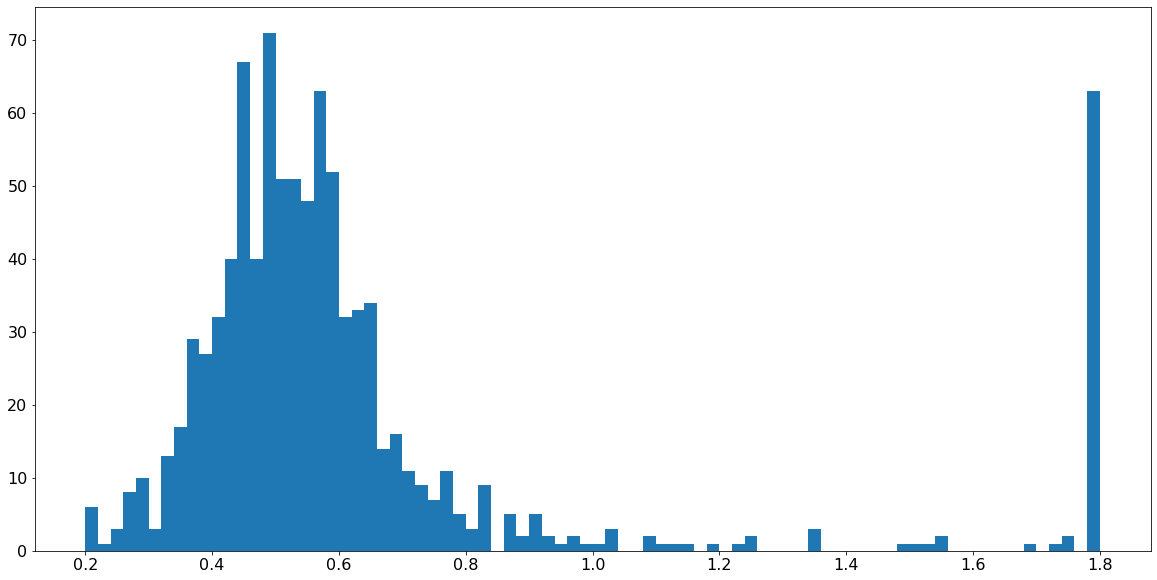

In [14]:
plt.figure(figsize=(20, 10))
plt.hist(ks.values(), bins=80)

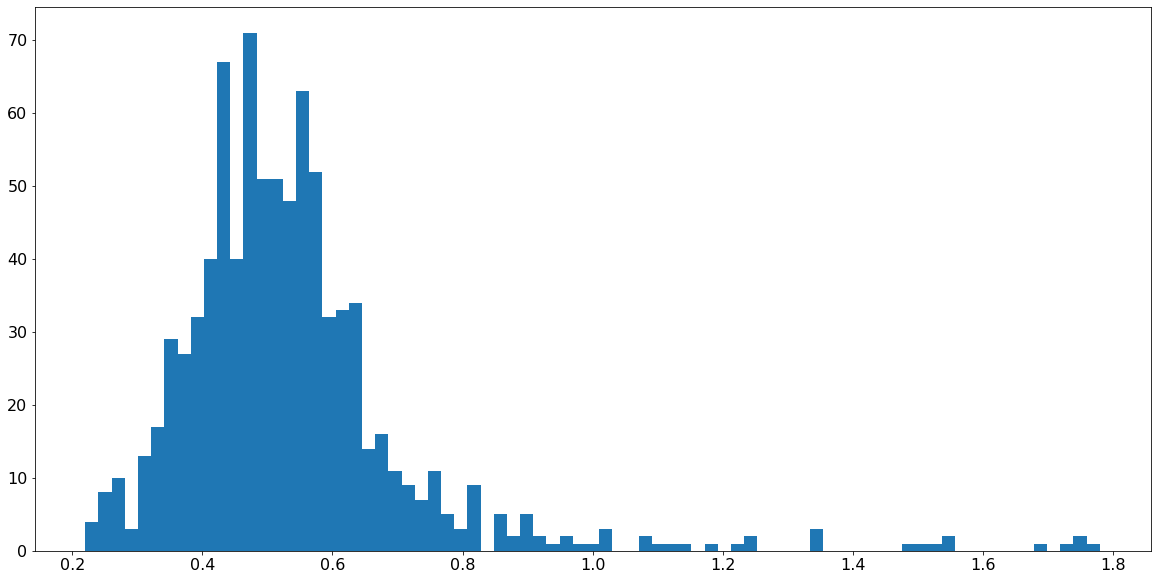

In [15]:
plt.figure(figsize=(20, 10))
counts, bins, _ = plt.hist([ x for x in ks.values() if x > 0.201 and x < 1.799 ], bins=77)

In [16]:
counts, bins

(array([ 4.,  8., 10.,  3., 13., 17., 29., 27., 32., 40., 67., 40., 71.,
        51., 51., 48., 63., 52., 32., 33., 34., 14., 16., 11.,  9.,  7.,
        11.,  5.,  3.,  9.,  0.,  5.,  2.,  5.,  2.,  1.,  2.,  1.,  1.,
         3.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  2.,  0.,
         0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  2.,  1.]),
 array([0.22      , 0.24025974, 0.26051948, 0.28077922, 0.30103896,
        0.3212987 , 0.34155844, 0.36181818, 0.38207792, 0.40233766,
        0.4225974 , 0.44285714, 0.46311688, 0.48337662, 0.50363636,
        0.5238961 , 0.54415584, 0.56441558, 0.58467532, 0.60493506,
        0.62519481, 0.64545455, 0.66571429, 0.68597403, 0.70623377,
        0.72649351, 0.74675325, 0.76701299, 0.78727273, 0.80753247,
        0.82779221, 0.84805195, 0.86831169, 0.88857143, 0.90883117,
        0.92909091, 0.94935065, 0.96961039, 0.98987013, 1.01012987,
        1.03038961, 1

In [11]:
def gaussian(x, *pars):
    A, mu, sigma = pars
    return A * np.exp(-(x-mu)**2/2/sigma**2)

(0.4890612720031042, 0.004024322092850655, 0.11176523915787599)

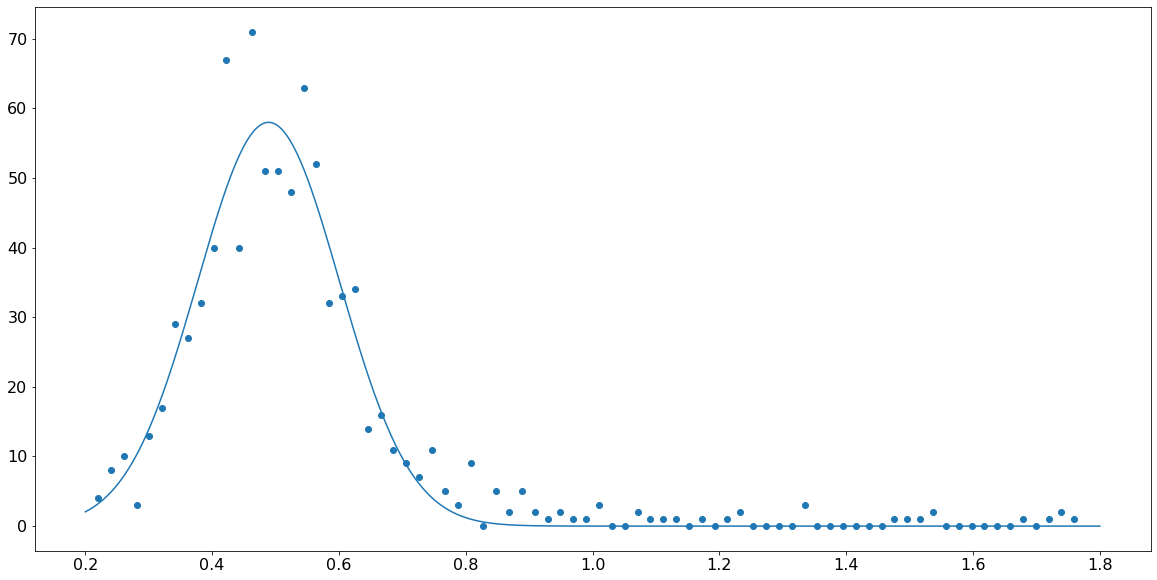

In [18]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins[:-1], counts, p0=[1, 0, 1])

xs = np.linspace(0.2, 1.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins[:-1], counts)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [ ]:
ks_hr = {}
qs_hr = {}
for gaia_id in tqdm(DF[:1000][GAIA_ID_COLNAME]):
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_hr[gaia_id] = min_k
    qs_hr[gaia_id] = min_q

  0%|                                                                                                 | 0/1000 [00:00<?, ?it/s]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  0%|                                                                                     | 1/1000 [01:46<29:39:24, 106.87s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  0%|▏                                                                                     | 2/1000 [02:23<18:12:04, 65.66s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  0%|▎                                                                                     | 3/1000 [03:00<14:34:47, 52.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  0%|▎                                                                                     | 4/1000 [03:39<12:59:28, 46.96s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  0%|▍                                                                                     | 5/1000 [04:33<13:45:18, 49.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|▌                                                                                     | 6/1000 [06:48<21:41:38, 78.57s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|▌                                                                                     | 7/1000 [08:01<21:09:23, 76.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|▋                                                                                     | 8/1000 [08:39<17:48:01, 64.60s/it]

Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|▉                                                                                    | 11/1000 [10:32<13:28:43, 49.06s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|█                                                                                    | 12/1000 [10:47<11:24:01, 41.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|█                                                                                    | 13/1000 [12:57<17:07:43, 62.48s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  1%|█▏                                                                                   | 14/1000 [13:48<16:17:34, 59.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▎                                                                                   | 15/1000 [15:28<19:12:04, 70.18s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▎                                                                                   | 16/1000 [15:39<14:45:31, 54.00s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▌                                                                                    | 18/1000 [15:44<8:34:24, 31.43s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▌                                                                                   | 19/1000 [16:51<10:53:11, 39.95s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▋                                                                                   | 20/1000 [17:53<12:23:24, 45.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▊                                                                                   | 21/1000 [19:46<17:15:54, 63.49s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▊                                                                                   | 22/1000 [20:16<14:46:56, 54.41s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|█▉                                                                                   | 23/1000 [22:23<20:17:30, 74.77s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|██                                                                                   | 24/1000 [23:10<18:06:01, 66.76s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  2%|██▏                                                                                  | 25/1000 [23:42<15:21:59, 56.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  3%|██▏                                                                                  | 26/1000 [24:36<15:08:17, 55.95s/it]

Could not get SDSS data
Could not get SDSS data
Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  3%|██▌                                                                                  | 30/1000 [26:48<11:11:54, 41.56s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  3%|██▊                                                                                   | 32/1000 [27:37<9:45:15, 36.28s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  3%|██▊                                                                                   | 33/1000 [27:58<8:59:19, 33.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  3%|██▉                                                                                   | 34/1000 [28:41<9:31:45, 35.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|██▉                                                                                  | 35/1000 [29:34<10:35:56, 39.54s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███                                                                                  | 36/1000 [31:44<16:28:42, 61.54s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▏                                                                                 | 38/1000 [32:54<13:32:49, 50.70s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▎                                                                                 | 39/1000 [33:51<13:55:01, 52.13s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▍                                                                                 | 40/1000 [35:59<18:50:26, 70.65s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▍                                                                                 | 41/1000 [37:14<19:09:08, 71.90s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▌                                                                                 | 42/1000 [38:18<18:33:32, 69.74s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▋                                                                                 | 43/1000 [39:13<17:24:57, 65.51s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▋                                                                                 | 44/1000 [40:06<16:26:27, 61.91s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  4%|███▊                                                                                 | 45/1000 [41:27<17:53:42, 67.46s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  5%|███▉                                                                                 | 46/1000 [42:14<16:15:38, 61.36s/it]

calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


  5%|███▉                                                                                 | 47/1000 [43:03<15:18:14, 57.81s/it]

Could not get SDSS data
calibrating gaia...



Processing data:   0%|                                                                                 | 0/1 [00:00<?, ?spec/s]
                                                                                                                               

done.


In [ ]:
ks_hr

In [ ]:
qs_hr

In [ ]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist(ks_hr.values(), bins=240)

In [ ]:
plt.figure(figsize=(20, 10))
counts2, bins2, _ = plt.hist([ x for x in ks_hr.values() if x > 0.20251 and x < 0.795 ], bins=235)

In [ ]:
(A_fit, mu_fit, sigma_fit), var_matrix = curve_fit(gaussian, bins2[:-1], counts2, p0=[1, 0, 1])

xs = np.linspace(0.2, 0.8, 2000)
plt.figure(figsize=(20, 10))
plt.scatter(bins2[:-1], counts2)
plt.plot(xs, gaussian(xs, A_fit, mu_fit, sigma_fit))
mu_fit, var_matrix[1, 1]**.5, sigma_fit

In [ ]:
ks_adj = {}
qs_adj = {}
for gaia_id in DF[:1000][GAIA_ID_COLNAME]:
    min_k, min_rmse, min_q = 100, 100, 100
    gaia_flux = plot_conv_get_gaia(gaia_id=gaia_id)
    if gaia_flux is None:
        continue
    else:
        gaia_flux *= qs_hr[gaia_id]
            
    for k in np.arange(0.2, 0.8, 0.0025):
        rmse, q = plot_conv_k_rms(gaia_flux, gaia_id=gaia_id, k=k)
        if rmse < min_rmse:
            min_rmse = rmse
            min_k = k
            min_q = q
        else:
            break
        
    ks_adj[gaia_id] = min_k
    qs_adj[gaia_id] = min_q

In [ ]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist(ks_adj.values(), bins=240)

In [ ]:
plt.figure(figsize=(20, 10))
counts_adj, bins_adj, _ = plt.hist([ x for x in ks_adj.values() if x > 0.20251 and x < 0.795 ], bins=235)

In [ ]:
bins_adj

In [ ]:
plt.hist(list({ gid: ks_hr[gid] - ks_adj[gid] for gid in ks_hr.keys() if np.abs(ks_hr[gid]) > 0.8 }.values()), bins=20)

In [ ]:
plt.hist([ x for x in qs_hr.values() if abs(x-1) < 0.5], bins=30)

In [ ]:
ks_adj

In [ ]:
qs_adj